In [1]:
from pylab import *
import matplotlib.pyplot as plt
# import bloch_phase as bloch
from progressbar import ProgressBar, Percentage, Bar, ETA
import pulse

In [2]:
import bloch
def zMag(exchangeTime, LTMs, pools, duration, freqdata):

    gyrogamma = 267.522 #units are in microTesla
    power = math.pi/(gyrogamma*duration)

    pulseShape = 'bp' 
    # specify 'bp', 'gaussian', 'fermi', 'sinc', or 'sg' for sinc-guassian

    sat_pulse_amplitude = power# in micro Tesla
    sat_pulse_duration = duration# in seconds
    post_pulse_delay = exchangeTime# in seconds
    crusher_gradient = False # define True or False

    pulse_repeats = 1

    hard_pulse = pulse.returnPulse(pulseShape, sat_pulse_duration, post_pulse_delay, pulseAmplitude=sat_pulse_amplitude)

	# Solve the Bloch equations
	#mx, my, b=bloch.solve((freewater, macromolecular), freqdata, hard_pulse, crusher=False, magnetic_field=11.7, pulse_repeat = LTMs, post_dynamic_delay=inf)
    b=bloch.solve(pools, freqdata, hard_pulse, crusher=False, magnetic_field=7.0, pulse_repeat = LTMs, post_dynamic_delay=100)
    return b


# labelling efficiency

In [3]:
## Define pools
freewater = bloch.Pool('freewater', t1 = 1.6, t2 = 0.062, lifetime = 1., chemical_shift = 1000.0, concentration = 111200)
macromolecular = bloch.Pool('macromolecular', t1 = 1, t2 = 9e-6, lifetime = 1/40., chemical_shift = 0.0001, concentration =0.001)

amide = bloch.Pool('amide', t1 = 1., t2 = 0.1, lifetime = 1/1e4, chemical_shift = 10, concentration = 72.)


In [4]:
# need to change RF pulse shape to gs

field = 42.58*7.0
freqdata = linspace(15,-15,101)
pulseDuration = 1e2/1e6
ltmDur = 2/1000.
LTMs = 1

pools=(freewater, amide, macromolecular)

invers_Sim = zMag(0, LTMs, pools, pulseDuration, freqdata)
invers_Sim1 = invers_Sim[7,:,-1]*111200/50.
invers_Sim2 = invers_Sim[6,:,-1]

In [9]:
##================================================
##
## Setup the Pulse
##
##================================================

field = 42.58*7.0
freqdata = r_[20]
duration = logspace(1., 3., 51)/1e6    #us
exchangeTime = r_[2.]/1000.         #ms
LTMs = 1
exchangeRates = logspace(0, 5, 101)

##================================================
##
## Simulate magnetisation
##
##================================================
# freewater = bloch.Pool('freewater', t1 = 1.6, t2 = 0.062, lifetime = 1., chemical_shift = 1000.0, concentration = 111200)
# macromolecular = bloch.Pool('macromolecular', t1 = 1.6, t2 = 0.00006, lifetime = 1/60., chemical_shift = 0.001, concentration = 0.001)

freewater = bloch.Pool('freewater', t1 = 1.6, t2 = 0.062, lifetime = 1., chemical_shift = 1000.0, concentration = 111200)
macromolecular = bloch.Pool('macromolecular', t1 = 1, t2 = 9e-6, lifetime = 1/40., chemical_shift = 0.0001, concentration = 0.001)

b = zeros((9, len(exchangeRates), len(duration),len(freqdata)))
pbar = ProgressBar(widgets=['Flex Simulation ', Percentage(), Bar(), ETA()], maxval=b.shape[1]).start()


# varied duration and exchange rate
for ai, ami in enumerate(exchangeRates):
    for pi, p1 in enumerate(duration):
#         amide = bloch.Pool('amide', t1 = 1.6, t2 = 0.1, lifetime = 1/ami, chemical_shift = 10, concentration = 72.)
        amide = bloch.Pool('amide', t1 = 1., t2 = 0.1, lifetime = 1/ami, chemical_shift = 20, concentration = 72.)

        pools = (freewater, amide, macromolecular)
        temp = zMag(0, LTMs, pools, p1, freqdata)
#               zMag(ltmDur, LTMs, pools, pulseDuration, freqdata)
        b[:, ai, pi] = temp[:,:,-1]
    pbar.update(pi)
pbar.finish()

Flex Simulation 100%|############################################|Time: 0:00:25


In [10]:
Z = 1-b[7,:,:,-1]*111200/70.

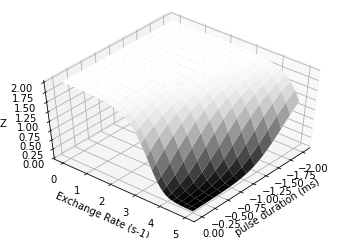

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 


fig = plt.figure()
ax = fig.gca(projection='3d')
Y = exchangeRates
X = duration*1e3
X, Y = np.meshgrid(X, Y)
Z = 1-b[7,:,:,-1]*111200/72.

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

ax.plot_surface(log10(X), log10(Y), Z, rstride=4, cstride=4, alpha=1., shade=True, cmap=cm.Greys_r)
# cset = ax.contour(log10(X), log10(Y), Z, 2, zdir='x', colors='k',offset=-0.5)
# cset = ax.contour(log10(X), log10(Y), Z, 2, zdir='y', colors='k', offset=-3.)
# cset = ax.contour(log10(X), log10(Y), Z, 4, zdir='z', colors='k', offset=0.5)

# clabel(cset, fontsize=100)

ax.set_ylabel('Exchange Rate (s-1)')
# ax.set_xlim(-0.5, 5)
ax.set_xlabel('pulse duration (ms)')
# ax.set_ylim(-3., 0)

ax.set_zlabel('Z')
ax.set_zlim(0.0, 2)

ax.view_init(elev=50, azim=40)
plt.show()


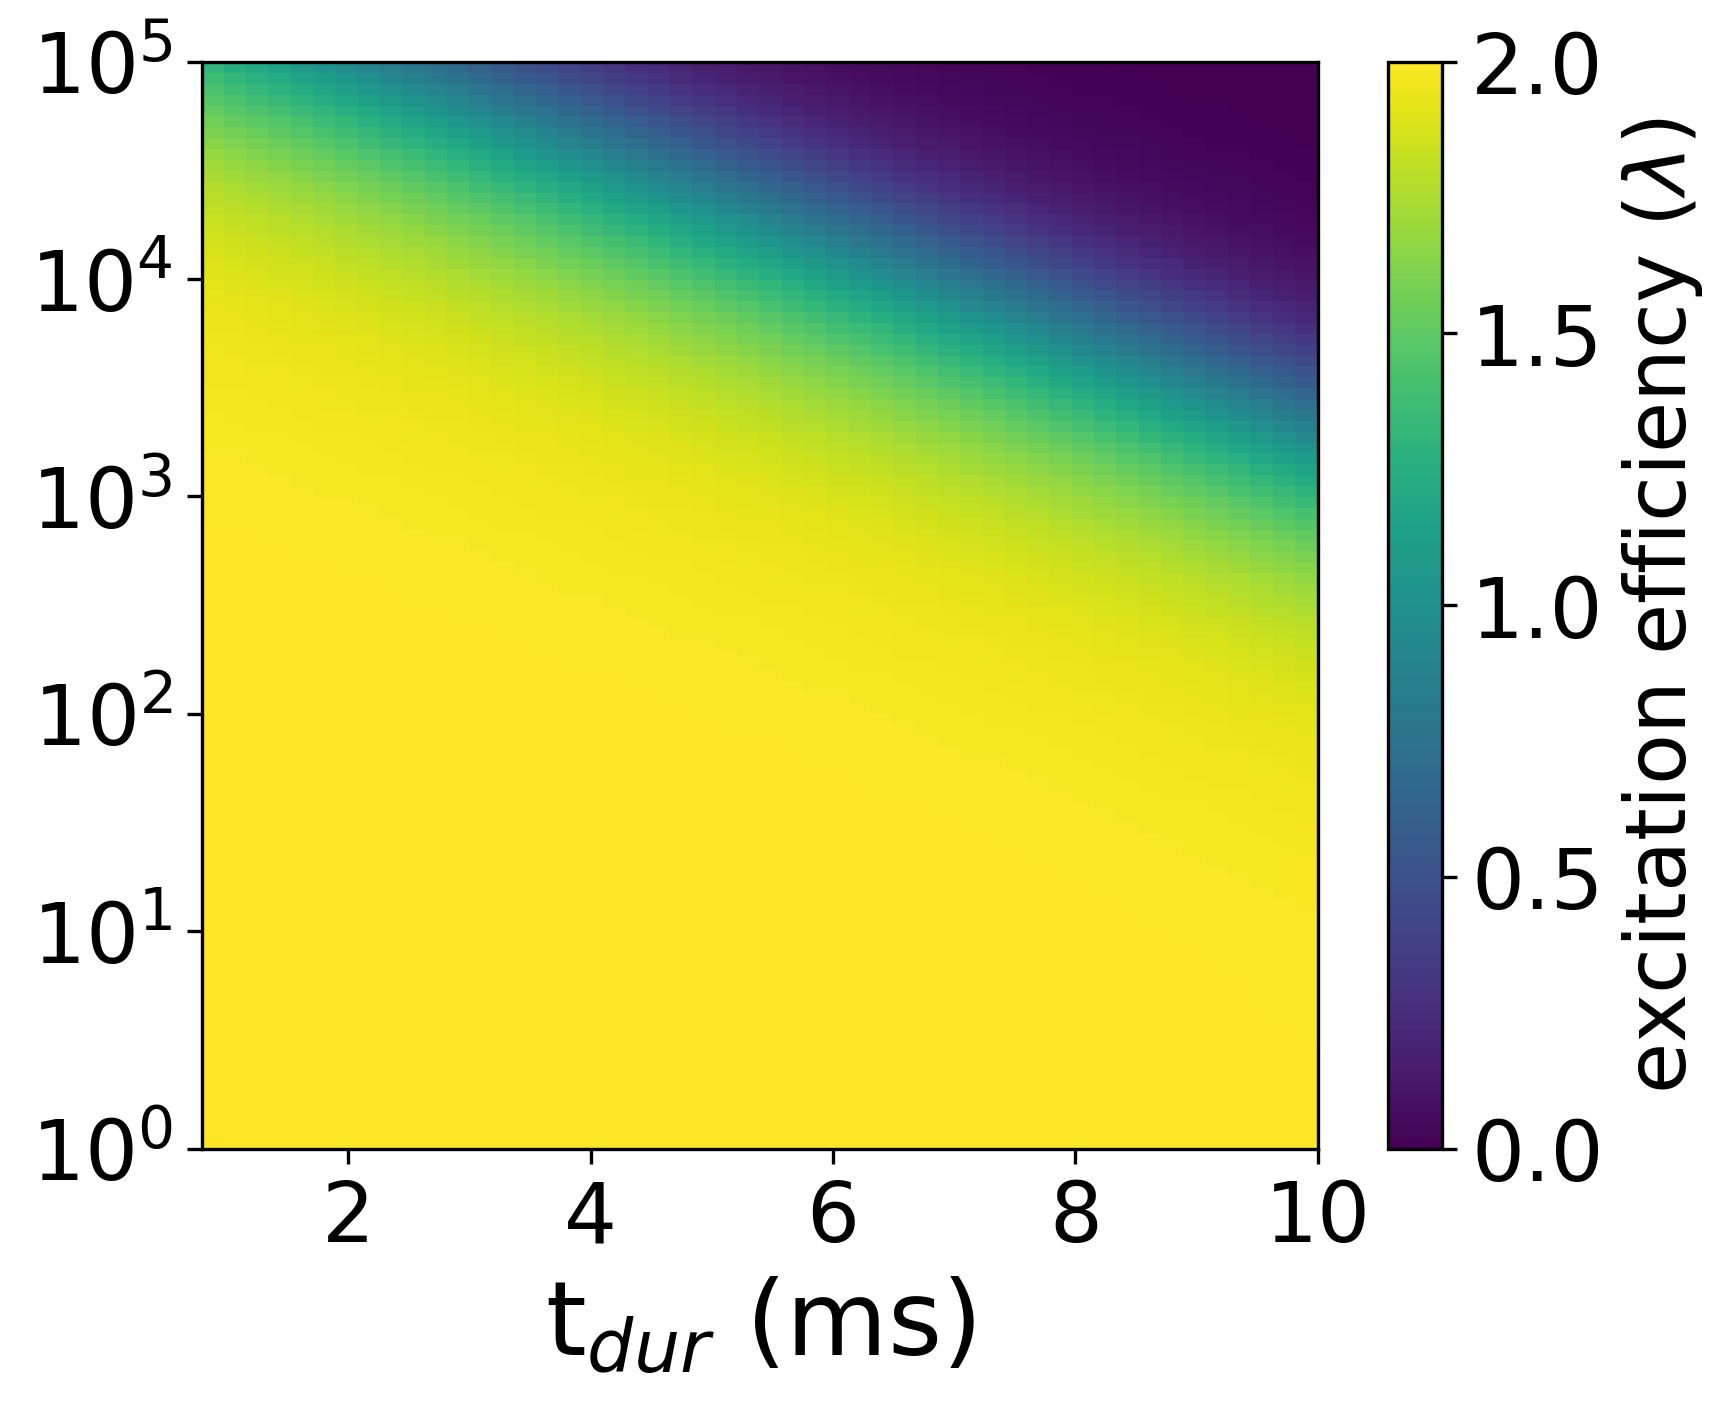

In [12]:
fig, ax = plt.subplots(figsize=(6,4.8),dpi=300)

y=log10(exchangeRates)
x=log(duration*1e3)

im = ax.pcolormesh(x, y , Z, vmin=0, vmax=2)
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(r'excitation efficiency ($\lambda$)', fontsize=20)

# cbar=fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=20) 

y_label_list = ['10$^0$','10$^1$','10$^2$','10$^3$','10$^4$','10$^5$']
ax.set_yticklabels(y_label_list, fontsize=20)

x_label_list = ['0','2','4','6','8','10']
ax.set_xticklabels(x_label_list, fontsize=20)

# plt.ylabel('k$_{sw}$ (s$^{-1}$)', fontsize=25)
plt.xlabel('t$_{dur}}$ (ms)', fontsize=25)
# plt.title('saturation efficiency ($\\lambda$)', fontsize=25)
# l(r'$\lambda$')

plt.show()